In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import yaml
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os


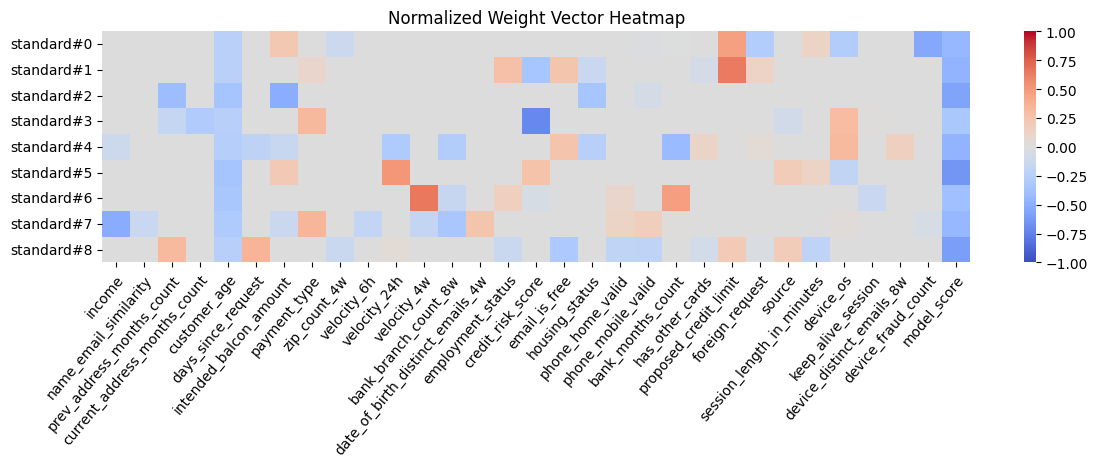

In [3]:
scen = 'alert_0.05-data_0.05'
l = 0.057
prop = pd.read_parquet(f'../../Data_and_models/experts/{scen}-l_{l}/full_w_table.parquet')

w = prop.drop(columns =['fp_beta', 'fn_beta', 'alpha'])
w = w.div(np.sqrt(np.square(w).sum(axis=1)), axis = 0)

f, ax = plt.subplots(figsize=(14, 3))
sns.heatmap(w, robust=True, cmap = 'coolwarm', vmax = 1, vmin = -1, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Normalized Weight Vector Heatmap")
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.savefig("w_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
scens = ['alert_0.05-data_0.05','alert_0.15-data_0.05']
costs = [0.0114,0.057,0.285]

In [6]:
test_res = dict()
val_res = dict()
train_res = dict()
test_comp = dict()
classifier_h = dict()
classifier_h_properties = dict()
for scen in scens:
    test_res[scen] = dict()
    val_res[scen] = dict()
    train_res[scen] = dict()
    test_comp[scen] = dict()
    classifier_h[scen] = dict()
    classifier_h_properties[scen] = dict()
    for l in costs:
        data = pd.read_parquet(f'../../Data_and_models/data/alerts/{scen}.parquet')
        train = data.loc[(data["month"] > 2) & (data["month"] < 6)]
        val = data.loc[data["month"] == 6]
        test = data.loc[data["month"] == 7]


        with open(f'../../Data_and_models/classifier_h/selected_models/{scen}-l_{l}/best_model.pickle', 'rb') as infile:
            classifier_h[scen][l] = pickle.load(infile)

        with open(f'../../Data_and_models/classifier_h/selected_models/{scen}-l_{l}/model_properties.yaml', 'r') as infile:
            classifier_h_properties[scen][l] = yaml.safe_load(infile)


        val_preds = pd.read_parquet(f'../../Data_and_models/experts/{scen}-l_{l}/train_predictions.parquet')
        train_test_preds = pd.read_parquet(f'../../Data_and_models/experts/{scen}-l_{l}/deployment_predictions.parquet')
        train_preds = train_test_preds.loc[train.index]
        test_preds = train_test_preds.loc[test.index]

        binarized_val = (val_preds>0.5).astype(int)
        binarized_test = (test_preds>0.5).astype(int)
        binarized_train = (train_preds>0.5).astype(int)

        results_train = pd.DataFrame()
        for agent in binarized_train.columns:
            tn, fp, fn, tp = confusion_matrix(train['fraud_bool'], binarized_train[agent]).ravel()
            results_train.loc[agent,'tn'] = tn
            results_train.loc[agent,'tp'] = tp
            results_train.loc[agent,'fn'] = fn
            results_train.loc[agent,'fp'] = fp
            results_train.loc[agent,'fpr'] = fp/(fp+tn)
            results_train.loc[agent,'fnr'] = fn/(fn+tp)
            results_train.loc[agent,'cost'] = (l*fp+fn)/(fp+fn+tp+tn)

        tn, fp, fn, tp = confusion_matrix(train['fraud_bool'], np.ones(len(train['fraud_bool']))).ravel()
        results_train.loc['reject_all','tn'] = tn
        results_train.loc['reject_all','tp'] = tp
        results_train.loc['reject_all','fn'] = fn
        results_train.loc['reject_all','fp'] = fp
        results_train.loc['reject_all','fpr'] = fp/(fp+tn)
        results_train.loc['reject_all','fnr'] = fn/(fn+tp)
        results_train.loc['reject_all','cost'] = (l*fp+fn)/(fp+fn+tp+tn)

        results_train['expert'] = results_train.index
        results_train['Decisions'] = results_train['expert'].apply(lambda x: x.split('#')[0])
        results_train.loc['model#0','Decisions'] = 'Classifier h'

        results_val = pd.DataFrame()
        for agent in binarized_val.columns:
            tn, fp, fn, tp = confusion_matrix(val['fraud_bool'], binarized_val[agent]).ravel()
            results_val.loc[agent,'tn'] = tn
            results_val.loc[agent,'tp'] = tp
            results_val.loc[agent,'fn'] = fn
            results_val.loc[agent,'fp'] = fp
            results_val.loc[agent,'fpr'] = fp/(fp+tn)
            results_val.loc[agent,'fnr'] = fn/(fn+tp)
            results_val.loc[agent,'cost'] = (l*fp+fn)/(fp+fn+tp+tn)


        tn, fp, fn, tp = confusion_matrix(val['fraud_bool'], np.ones(len(val['fraud_bool']))).ravel()
        results_val.loc['reject_all','tn'] = tn
        results_val.loc['reject_all','tp'] = tp
        results_val.loc['reject_all','fn'] = fn
        results_val.loc['reject_all','fp'] = fp
        results_val.loc['reject_all','fpr'] = fp/(fp+tn)
        results_val.loc['reject_all','fnr'] = fn/(fn+tp)
        results_val.loc['reject_all','cost'] = (l*fp+fn)/(fp+fn+tp+tn)

        results_val['expert'] = results_val.index
        results_val['Decisions'] = results_val['expert'].apply(lambda x: x.split('#')[0])
        results_val.loc['model#0','Decisions'] = 'Classifier h'


        results_test = pd.DataFrame()
        for agent in binarized_test.columns:
            tn, fp, fn, tp = confusion_matrix(test['fraud_bool'], binarized_test[agent]).ravel()
            results_test.loc[agent,'tn'] = tn
            results_test.loc[agent,'tp'] = tp
            results_test.loc[agent,'fn'] = fn
            results_test.loc[agent,'fp'] = fp
            results_test.loc[agent,'fpr'] = fp/(fp+tn)
            results_test.loc[agent,'fnr'] = fn/(fn+tp)
            results_test.loc[agent,'cost'] = (l*fp+fn)/(fp+fn+tp+tn)


        tn, fp, fn, tp = confusion_matrix(test['fraud_bool'], np.ones(len(test['fraud_bool']))).ravel()
        results_test.loc['reject_all','tn'] = tn
        results_test.loc['reject_all','tp'] = tp
        results_test.loc['reject_all','fn'] = fn
        results_test.loc['reject_all','fp'] = fp
        results_test.loc['reject_all','fpr'] = fp/(fp+tn)
        results_test.loc['reject_all','fnr'] = fn/(fn+tp)
        results_test.loc['reject_all','cost'] = (l*fp+fn)/(fp+fn+tp+tn)


        results_test['expert'] = results_test.index
        results_test['Decisions'] = results_test['expert'].apply(lambda x: x.split('#')[0])
        results_test.loc['model#0','Decisions'] = 'Classifier h'


        complementary_test = pd.DataFrame(columns = binarized_test.columns, index = binarized_test.columns)
        for a1 in binarized_test.columns:
            for a2 in binarized_test.columns:
                complementary_test.loc[a1,a2] = ((binarized_test[a1] == test['fraud_bool']) & (binarized_test[a2] != test['fraud_bool'])).astype(int).mean()
        
        test_res[scen][l] = results_test
        val_res[scen][l] = results_val
        train_res[scen][l] = results_train
        test_comp[scen][l] = complementary_test



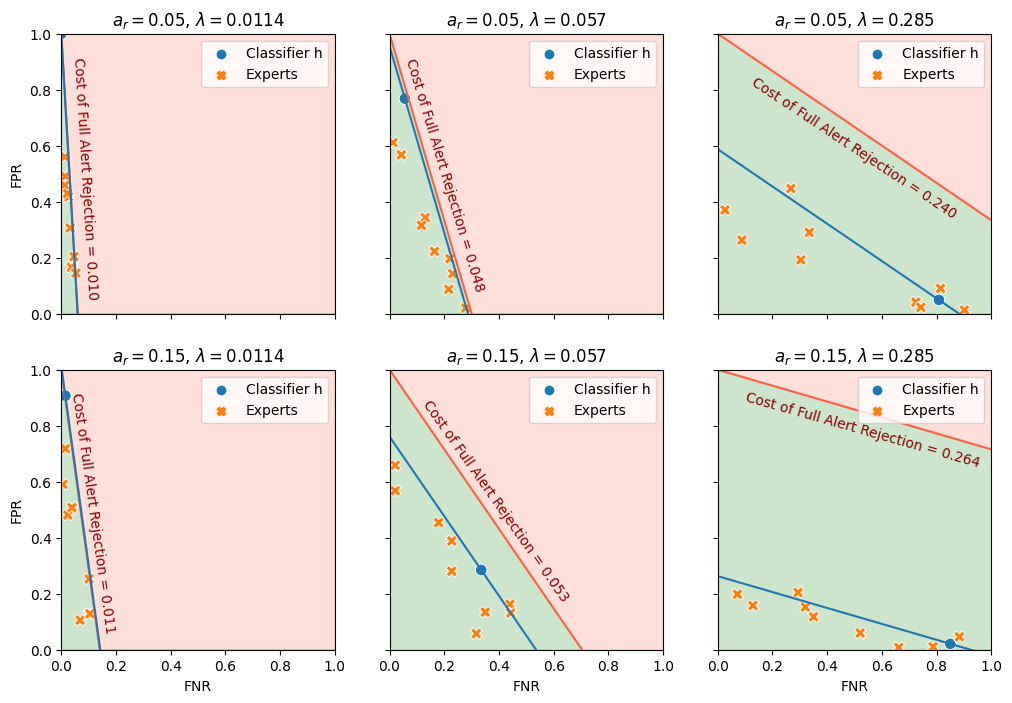

In [7]:
f, ax = plt.subplots(figsize=(12, 8),nrows = 2, ncols = 3,sharey = True, sharex = True)
i=0
pos = [[47,58,120],[40,120,100]]
off = [[0.7,0.1,-0.1],[0.2,0.05,-0.08]]
titles = [[r'$a_r = 0.05$, $\lambda = 0.0114$',r'$a_r = 0.05$, $\lambda = 0.057$',r'$a_r = 0.05$, $\lambda = 0.285$'],
[r'$a_r = 0.15$, $\lambda = 0.0114$',r'$a_r = 0.15$, $\lambda = 0.057$',r'$a_r = 0.15$, $\lambda = 0.285$']]
for scen in scens:
    j = 0
    for l in costs:
        test_res[scen][l].replace({'standard':'Experts'},inplace = True)
        prev = classifier_h_properties[scen][l]['prev_test']
        cost = test_res[scen][l].loc['reject_all','cost']
        slope = -(prev)/(l*(1-prev))
        b = cost/(l*(1-prev))
        ax[i][j].plot(np.arange(0,1,0.001), np.arange(0,1,0.001)*slope + b, color = 'tomato')
        ax[i][j].text(np.arange(0,1,0.001)[pos[i][j]], np.arange(0,1,0.001)[pos[i][j]]*slope + b + off[i][j], f'Cost of Full Alert Rejection = {cost:.3f}', color = 'darkred', rotation = 360*np.arctan(slope)/(2*np.pi), rotation_mode = 'anchor')
        ax[i][j].fill_between(x=np.arange(0,1.001,0.001),y1 = np.arange(0,1.001,0.001)*slope + b, alpha = 0.2, color = 'green')
        ax[i][j].fill_between(x=np.arange(0,1.001,0.001),y1 = np.arange(0,1.001,0.001)*slope + b, y2 = np.ones(len(np.arange(0,1.001,0.001))), alpha = 0.2, color = 'tomato')
        prev = classifier_h_properties[scen][l]['prev_test']
        cost = classifier_h_properties[scen][l]['cost_test']
        slope = -(prev)/(l*(1-prev))
        b = cost/(l*(1-prev))
        sns.scatterplot(ax = ax[i][j], data=test_res[scen][l].drop('reject_all'), x='fnr', y='fpr', hue='Decisions', style='Decisions',  palette=["C0", "C1"], s = 70)
        ax[i][j].plot(np.arange(0,1,0.01), np.arange(0,1,0.01)*slope + b)

        ax[i][j].set_ylim([0,1])
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_xlabel('FNR')
        ax[i][j].set_ylabel('FPR')
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend(loc = 'upper right')
        
        j+=1
    i+=1

plt.savefig("FPR_FNR_EXPERTS.pdf", format="pdf", bbox_inches="tight")
plt.show()

/home/leonardo.alves/anaconda3/envs/openl2d-env/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


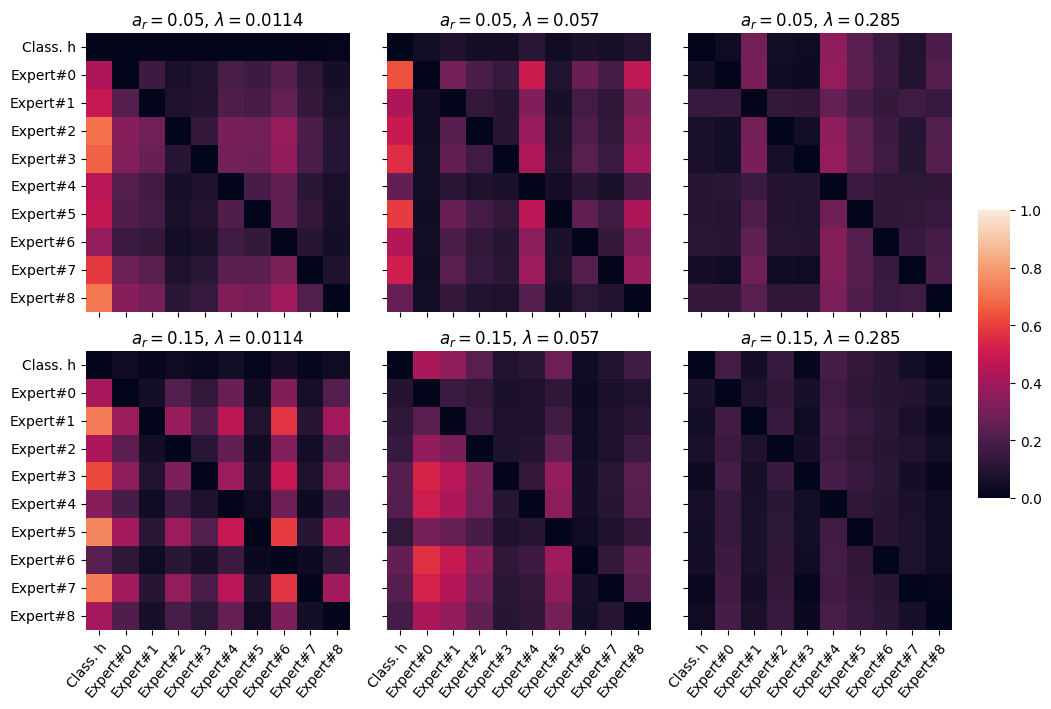

In [8]:
f, ax = plt.subplots(figsize=(12*0.9, 8*0.9),nrows = 2, ncols = 3,sharey = True, sharex = True)
i=0
cbar_ax = f.add_axes([.91, .3, .03, .4])
titles = [[r'$a_r = 0.05$, $\lambda = 0.0114$',r'$a_r = 0.05$, $\lambda = 0.057$',r'$a_r = 0.05$, $\lambda = 0.285$'],
[r'$a_r = 0.15$, $\lambda = 0.0114$',r'$a_r = 0.15$, $\lambda = 0.057$',r'$a_r = 0.15$, $\lambda = 0.285$']]
for scen in scens:
    j = 0
    for l in costs:
        test_comp[scen][l].rename(index = {
            'standard#0':'Expert#0',
            'standard#1':'Expert#1',
            'standard#2':'Expert#2',
            'standard#3':'Expert#3',
            'standard#5':'Expert#5',
            'standard#4':'Expert#4',
            'standard#6':'Expert#6',
            'standard#7':'Expert#7',
            'standard#8':'Expert#8',
            'model#0':'Class. h',

        }, columns = {
            'standard#0':'Expert#0',
            'standard#1':'Expert#1',
            'standard#2':'Expert#2',
            'standard#3':'Expert#3',
            'standard#4':'Expert#4',
            'standard#5':'Expert#5',
            'standard#6':'Expert#6',
            'standard#7':'Expert#7',
            'standard#8':'Expert#8',
            'model#0':'Class. h',

        }, inplace = True)
        sns.heatmap(ax = ax[i][j], data=test_comp[scen][l].astype(float),vmin = 0, vmax = 1, cbar = (j==0)&(i==0), cbar_ax = cbar_ax)

        ax[i][j].set_title(titles[i][j])
        t = ax[i][j].get_xticklabels()
        ax[i][j].set_xticklabels(t, rotation = 50, rotation_mode = 'anchor', ha = 'right')
        
        
        j+=1
    i+=1


f.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("Complementarity.pdf", format="pdf", bbox_inches="tight")

plt.show()